# PepBERT - Small - UniRef100

Saved embeddings and t-SNE coordinates to ../data/embeddings/Small_UniRef100_PepBERT.csv


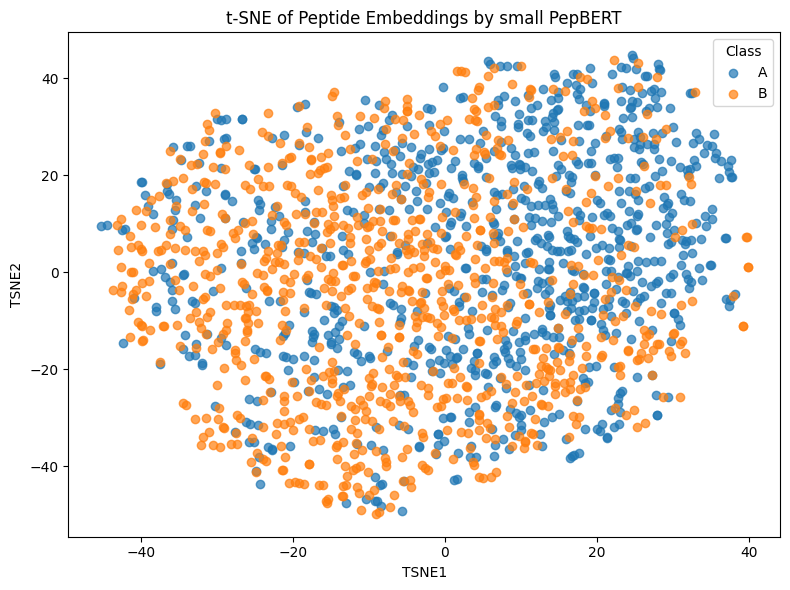

In [32]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tokenizers import Tokenizer
from huggingface_hub import hf_hub_download
import importlib.util

# Define the repository ID for the PepBERT model
repo_id = "dzjxzyd/PepBERT-small-UniRef100"

# Function to load a module from the Hugging Face Hub
def load_module_from_hub(repo_id: str, filename: str):
    file_path = hf_hub_download(repo_id=repo_id, filename=filename)
    module_name = os.path.splitext(os.path.basename(file_path))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Load model architecture and configuration
model_module = load_module_from_hub(repo_id, "model.py")
config_module = load_module_from_hub(repo_id, "config.py")
build_transformer = model_module.build_transformer
get_config = config_module.get_config

# Load the tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json")
tokenizer = Tokenizer.from_file(tokenizer_path)

# Download model weights
weights_path = hf_hub_download(repo_id=repo_id, filename="tmodel_12.pt")

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = get_config()
model = build_transformer(
    src_vocab_size=tokenizer.get_vocab_size(),
    src_seq_len=config["seq_len"],
    d_model=config["d_model"]
)
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state["model_state_dict"])
model.to(device).eval()

# Function to encode a single peptide sequence
def encode_peptide(sequence):
    # Add start and end tokens
    encoded_ids = [tokenizer.token_to_id("[SOS]")] + tokenizer.encode(sequence).ids + [tokenizer.token_to_id("[EOS]")]
    input_ids = torch.tensor([encoded_ids], dtype=torch.int64).to(device)
    encoder_mask = torch.ones((1, 1, 1, input_ids.size(1)), dtype=torch.int64).to(device)
    with torch.no_grad():
        emb = model.encode(input_ids, encoder_mask)
    # remove SOS/EOS positions and average
    emb_core = emb[:, 1:-1, :]
    emb_avg = emb_core.mean(dim=1)
    return emb_avg.squeeze().cpu().numpy()

# Load your dataset
df = pd.read_csv("../data/train.csv")  # ensure .csv extension

# Encode all sequences
embeddings_list = df["Sequence"].apply(encode_peptide).tolist()
# Create embeddings DataFrame
embeddings_df = pd.DataFrame(embeddings_list)

# Run t-SNE on the high-dimensional embeddings (exclude Intensity)
tsne = TSNE(n_components=2, random_state=42)
emb_tsne = tsne.fit_transform(embeddings_df.values)
# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Combine original data, embeddings, and t-SNE results
result_df = pd.concat([df[["Sequence", "Class"]], embeddings_df, tsne_df, df[["Intensity"]]], axis=1)

# Save combined DataFrame to a new CSV
output_path = "../data/embeddings/Small_UniRef100_PepBERT.csv"
result_df.to_csv(output_path, index=False)
print(f"Saved embeddings and t-SNE coordinates to {output_path}")

# Plotting
groups = result_df.groupby("Class")
plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title("t-SNE of Peptide Embeddings by small PepBERT")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig("../train_Small_UniRef100_PepBERT.png", dpi=300)
plt.show()

# PepBERT - Large - UniRef100

Saved embeddings and t-SNE coordinates to ../data/embeddings/Large_UniRef100_PepBERT.csv


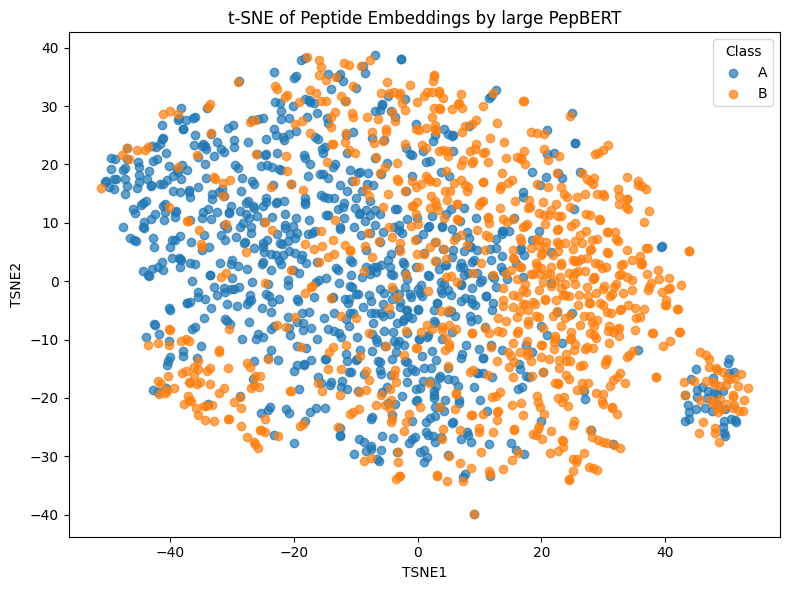

In [33]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tokenizers import Tokenizer
from huggingface_hub import hf_hub_download
import importlib.util

# Define the repository ID for the PepBERT model
repo_id = "dzjxzyd/PepBERT-Large-UniRef100"

# Function to load a module from the Hugging Face Hub
def load_module_from_hub(repo_id: str, filename: str):
    file_path = hf_hub_download(repo_id=repo_id, filename=filename)
    module_name = os.path.splitext(os.path.basename(file_path))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Load model architecture and configuration
model_module = load_module_from_hub(repo_id, "model.py")
config_module = load_module_from_hub(repo_id, "config.py")
build_transformer = model_module.build_transformer
get_config = config_module.get_config

# Load the tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json")
tokenizer = Tokenizer.from_file(tokenizer_path)

# Download model weights
weights_path = hf_hub_download(repo_id=repo_id, filename="tmodel_17.pt")

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = get_config()
model = build_transformer(
    src_vocab_size=tokenizer.get_vocab_size(),
    src_seq_len=config["seq_len"],
    d_model=config["d_model"]
)
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state["model_state_dict"])
model.to(device).eval()

# Function to encode a single peptide sequence
def encode_peptide(sequence):
    # Add start and end tokens
    encoded_ids = [tokenizer.token_to_id("[SOS]")] + tokenizer.encode(sequence).ids + [tokenizer.token_to_id("[EOS]")]
    input_ids = torch.tensor([encoded_ids], dtype=torch.int64).to(device)
    encoder_mask = torch.ones((1, 1, 1, input_ids.size(1)), dtype=torch.int64).to(device)
    with torch.no_grad():
        emb = model.encode(input_ids, encoder_mask)
    # remove SOS/EOS positions and average
    emb_core = emb[:, 1:-1, :]
    emb_avg = emb_core.mean(dim=1)
    return emb_avg.squeeze().cpu().numpy()

# Load your dataset
df = pd.read_csv("../data/train.csv")  # ensure .csv extension

# Encode all sequences
embeddings_list = df["Sequence"].apply(encode_peptide).tolist()
# Create embeddings DataFrame
embeddings_df = pd.DataFrame(embeddings_list)

# Run t-SNE on the high-dimensional embeddings (exclude Intensity)
tsne = TSNE(n_components=2, random_state=42)
emb_tsne = tsne.fit_transform(embeddings_df.values)
# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Combine original data, embeddings, and t-SNE results
result_df = pd.concat([df[["Sequence", "Class"]], embeddings_df, tsne_df, df[["Intensity"]]], axis=1)

# Save combined DataFrame to a new CSV
output_path = "../data/embeddings/Large_UniRef100_PepBERT.csv"
result_df.to_csv(output_path, index=False)
print(f"Saved embeddings and t-SNE coordinates to {output_path}")

# Plotting
groups = result_df.groupby("Class")
plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title("t-SNE of Peptide Embeddings by large PepBERT")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig("../train_Large_UniRef100_PepBERT.png", dpi=300)
plt.show()

# iFeature - AAC

Descriptor type: AAC
Saved AAC features and t-SNE coordinates to ../data/embeddings/iFeature_AAC.csv


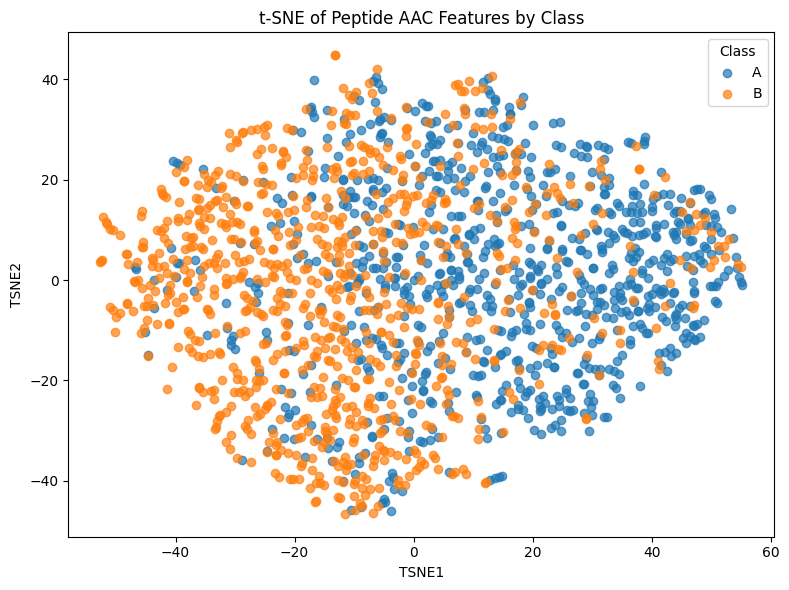

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import subprocess
import tempfile

# Function to run iFeature for a specific descriptor
def extract_ifeature(sequences, descriptor="AAC", ifeature_path="iFeature/iFeature.py"):
    # Create a temporary FASTA file
    with tempfile.NamedTemporaryFile(mode="w", suffix=".fasta", delete=False) as temp_fasta:
        for i, seq in enumerate(sequences):
            temp_fasta.write(f">{i}\n{seq}\n")
        temp_fasta_path = temp_fasta.name

    # Output file for features
    output_file = tempfile.NamedTemporaryFile(mode="r", suffix=".csv", delete=False).name

    # Run iFeature command
    cmd = [
        "python", ifeature_path,
        "--file", temp_fasta_path,
        "--type", descriptor,
        "--out", output_file
    ]
    subprocess.run(cmd, check=True)

    # Read the output CSV
    features_df = pd.read_csv(output_file, sep="\t")
    # Drop the first column (sequence IDs)
    features_df = features_df.drop(columns=["#"])

    # Clean up temporary files
    os.unlink(temp_fasta_path)
    os.unlink(output_file)

    return features_df

# Load your dataset
df = pd.read_csv("../data/train.csv")  # Ensure .csv extension

# Extract features using iFeature (e.g., AAC descriptor)
descriptor = "AAC"  # You can change to "DPC", "CTD", etc.
ifeature_path = "iFeature/iFeature.py"  # Adjust path to your iFeature installation
features_df = extract_ifeature(df["Sequence"], descriptor=descriptor, ifeature_path=ifeature_path)

# Run t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
emb_tsne = tsne.fit_transform(features_df.values)
# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Combine original data, features, and t-SNE results
result_df = pd.concat([df[["Sequence", "Class"]], features_df, tsne_df, df[["Intensity"]]], axis=1)

# Save combined DataFrame to a new CSV
output_path = f"../data/embeddings/iFeature_{descriptor}.csv"
result_df.to_csv(output_path, index=False)
print(f"Saved {descriptor} features and t-SNE coordinates to {output_path}")

# Plotting
groups = result_df.groupby("Class")
plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title(f"t-SNE of Peptide {descriptor} Features by Class")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig(f"../train_iFeature_{descriptor}.png", dpi=300)
plt.show()

# iFeature - DPC

Descriptor type: DPC
Saved DPC features and t-SNE coordinates to ../data/embeddings/iFeature_DPC.csv


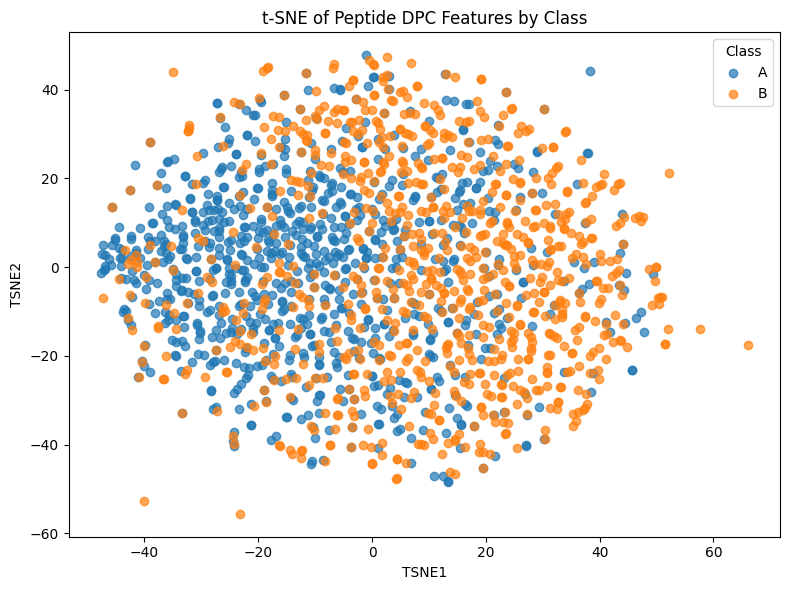

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import subprocess
import tempfile

# Function to run iFeature for a specific descriptor
def extract_ifeature(sequences, descriptor="AAC", ifeature_path="iFeature/iFeature.py"):
    # Create a temporary FASTA file
    with tempfile.NamedTemporaryFile(mode="w", suffix=".fasta", delete=False) as temp_fasta:
        for i, seq in enumerate(sequences):
            temp_fasta.write(f">{i}\n{seq}\n")
        temp_fasta_path = temp_fasta.name

    # Output file for features
    output_file = tempfile.NamedTemporaryFile(mode="r", suffix=".csv", delete=False).name

    # Run iFeature command
    cmd = [
        "python", ifeature_path,
        "--file", temp_fasta_path,
        "--type", descriptor,
        "--out", output_file
    ]
    subprocess.run(cmd, check=True)

    # Read the output CSV
    features_df = pd.read_csv(output_file, sep="\t")
    # Drop the first column (sequence IDs)
    features_df = features_df.drop(columns=["#"])

    # Clean up temporary files
    os.unlink(temp_fasta_path)
    os.unlink(output_file)

    return features_df

# Load your dataset
df = pd.read_csv("../data/train.csv")  # Ensure .csv extension

# Extract features using iFeature (e.g., AAC descriptor)
descriptor = "DPC"  # You can change to "DPC", "CTD", etc.
ifeature_path = "iFeature/iFeature.py"  # Adjust path to your iFeature installation
features_df = extract_ifeature(df["Sequence"], descriptor=descriptor, ifeature_path=ifeature_path)

# Run t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
emb_tsne = tsne.fit_transform(features_df.values)
# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Combine original data, features, and t-SNE results
result_df = pd.concat([df[["Sequence", "Class"]], features_df, tsne_df, df[["Intensity"]]], axis=1)

# Save combined DataFrame to a new CSV
output_path = f"../data/embeddings/iFeature_{descriptor}.csv"
result_df.to_csv(output_path, index=False)
print(f"Saved {descriptor} features and t-SNE coordinates to {output_path}")

# Plotting
groups = result_df.groupby("Class")
plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title(f"t-SNE of Peptide {descriptor} Features by Class")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig(f"../train_iFeature_{descriptor}.png", dpi=300)
plt.show()

# Kidera

Kidera encoded features and t-SNE coordinates saved to: ../data/embeddings/Kidera_encoded.csv


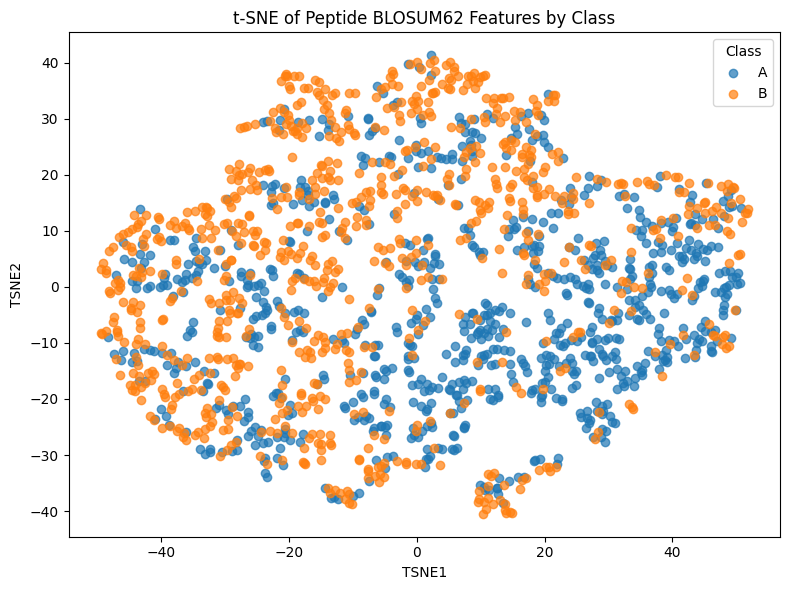

In [36]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load data
# Ensure 'train.csv' is in a 'data' directory relative to your script
try:
    df = pd.read_csv('../data/train.csv') # expects columns: ID, Sequence, Class, Intensity
except FileNotFoundError:
    print("Error: 'train.csv' not found. Make sure it's in the '../data/' directory.")
    sys.exit(1)

# 2. Define Kidera factor matrix manually with verified values
# Source: Kidera et al. (1985), Amino Acids mapped to 10-factor vectors (verified against common databases)
kidera = {
    'A': [-1.56, -1.67, -0.97, -0.27, -0.93, -0.78, -0.20, -0.08, 0.21, -0.48],
    'C': [1.02, 0.26, 1.77, -0.26, 0.77, -0.27, -0.32, 0.01, 0.05, 0.29],
    'D': [0.36, 1.47, 1.07, 0.42, 0.35, -0.23, 0.08, 0.09, -0.70, 0.43],
    'E': [-1.01, 0.69, 0.77, 0.38, 0.11, -0.52, -0.11, -0.05, -0.19, 0.17],
    'F': [1.13, 0.05, -0.11, 0.35, 1.34, 0.15, 0.50, -0.37, 0.28, -0.09],
    'G': [-2.37, 0.08, 0.67, 1.09, -0.98, 0.03, -0.08, 0.07, 0.15, 0.02],
    'H': [0.02, -0.66, 0.68, 0.64, 0.05, 0.21, 0.52, -0.20, -0.09, -0.04],
    'I': [1.64, -0.08, -1.33, -0.63, 0.50, 0.06, -0.19, -0.23, 0.01, -0.32],
    'K': [-0.61, 1.17, 0.60, 0.57, -0.23, -0.31, -0.34, -0.12, 0.45, -0.19],
    'L': [1.56, -0.09, -1.36, -0.58, 0.47, 0.05, -0.21, -0.21, -0.03, -0.26],
    'M': [1.12, 0.27, -0.39, -0.30, 0.08, -0.02, 0.21, -0.06, 0.08, -0.14],
    'N': [0.05, 0.90, 0.75, 0.73, -0.29, 0.08, 0.04, 0.11, -0.40, 0.27],
    'P': [-1.51, -0.04, 0.73, 0.63, -0.43, 0.16, 0.18, 0.07, -0.03, -0.06],
    'Q': [-0.10, 0.59, 0.81, 0.50, -0.26, -0.01, 0.08, 0.04, -0.36, 0.19],
    'R': [0.80, 1.63, 0.13, 0.14, 0.06, -0.20, -0.33, -0.09, 0.04, -0.15],
    'S': [-0.38, 0.48, 1.15, 0.70, -0.49, 0.10, 0.05, 0.07, -0.29, 0.21],
    'T': [-0.22, 0.02, 0.88, 0.72, 0.03, 0.09, 0.05, 0.09, -0.01, 0.01],
    'V': [1.36, -0.06, -1.04, -0.66, 0.36, 0.03, -0.13, -0.19, -0.01, -0.23],
    'W': [0.81, -0.09, -0.73, 0.56, 2.00, 0.15, 0.68, -0.46, 0.47, -0.20],
    'Y': [-0.07, -0.30, 0.03, 0.35, 1.07, -0.15, 0.31, -0.37, 0.40, -0.04]
}

# Function to compute mean Kidera factors per sequence
def seq_kidera(seq):
    factors = []
    for aa in seq:
        if aa in kidera:
            factors.append(kidera[aa])
        else:
            sys.exit(f"Error: Unknown amino acid '{aa}' in sequence.")
    return np.mean(factors, axis=0)

# Compute Kidera features for all sequences
kf_matrix = np.vstack(df['Sequence'].apply(seq_kidera))
kf_df = pd.DataFrame(kf_matrix, columns=[f'KF{i+1}' for i in range(kf_matrix.shape[1])])

# Run t-SNE on the Kidera features
tsne = TSNE(n_components=2, random_state=42, perplexity=30) # Added perplexity for better control
emb_tsne = tsne.fit_transform(kf_df.values)

# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Create a combined DataFrame including Sequence, Class, Kidera features, and t-SNE results
kidera_encoded_df = pd.concat([df[['Sequence', 'Class', 'Intensity']], kf_df, tsne_df], axis=1)

# Define the output path for the Kidera encoded CSV
output_dir = '../data/embeddings/'
os.makedirs(output_dir, exist_ok=True) # Ensure the directory exists
output_path = os.path.join(output_dir, 'Kidera_encoded.csv')

# Save the combined DataFrame to CSV
kidera_encoded_df.to_csv(output_path, index=False)
print(f"Kidera encoded features and t-SNE coordinates saved to: {output_path}")

# Plotting t-SNE results
groups = kidera_encoded_df.groupby("Class")
plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title("t-SNE of Peptide BLOSUM62 Features by Class")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig(f"../train_BLOSUM62_TSNE.png", dpi=300)
plt.show()

# BLOSUM62

BLOSUM62 encoded features and t-SNE coordinates saved to: ../data/embeddings/BLOSUM62_encoded.csv


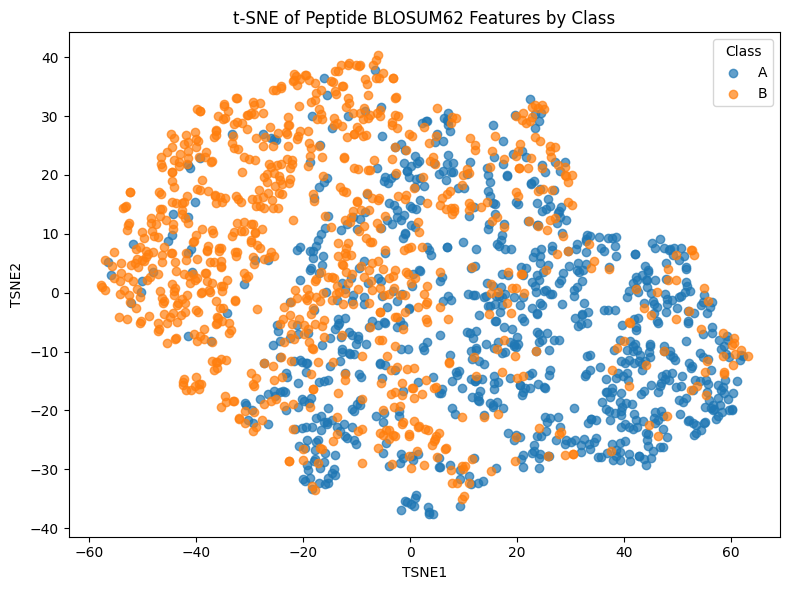

In [37]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load data
# Assumes 'train.csv' is in a 'data' directory one level up from the script's location.
# The DataFrame is expected to have 'ID', 'Sequence', and 'Class' columns.
try:
    df = pd.read_csv('../data/train.csv')
except FileNotFoundError:
    sys.exit("Error: 'train.csv' not found. Please ensure it's in '../data/'.")
except Exception as e:
    sys.exit(f"Error loading data: {e}")

# Ensure the 'Sequence' and 'Class' columns exist
if 'Sequence' not in df.columns:
    sys.exit("Error: 'Sequence' column not found in the input DataFrame.")
if 'Class' not in df.columns:
    sys.exit("Error: 'Class' column not found in the input DataFrame.")
if df['Sequence'].empty:
    sys.exit("Error: 'Sequence' column is empty in the input DataFrame.")

# 2. Define BLOSUM62 matrix manually
# This matrix represents the substitution scores for amino acid pairs.
# Source: Derived from standard BLOSUM62 matrices (e.g., NCBI).
# The order of amino acids in the dictionary keys and inner dictionary keys is crucial
# for consistent vector representation.
blosum62 = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': 0, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': 0, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -2, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4}
}

# Get an ordered list of amino acids to ensure consistent vector dimensions and order.
amino_acids = sorted(list(blosum62.keys()))

# Function to compute mean BLOSUM62 features per sequence
def seq_blosum62(seq):
    """
    Computes a fixed-size feature vector for a given peptide sequence
    by averaging the BLOSUM62 row vectors for each amino acid in the sequence.

    Args:
        seq (str): The peptide sequence.

    Returns:
        np.array: A 20-dimensional numpy array representing the mean BLOSUM62 features.
    """
    blosum_vectors = []
    for aa in seq:
        if aa in blosum62:
            # Extract the BLOSUM62 row for the current amino acid,
            # ensuring the order of elements matches 'amino_acids'.
            aa_vector = [blosum62[aa][other_aa] for other_aa in amino_acids]
            blosum_vectors.append(aa_vector)
        else:
            # If an unknown amino acid is encountered, terminate with an error.
            sys.exit(f"Error: Unknown amino acid '{aa}' in sequence '{seq}'.")

    # Handle empty sequences by returning a zero vector of the correct dimension.
    if not blosum_vectors:
        return np.zeros(len(amino_acids))
    
    # Compute the mean of all collected BLOSUM62 row vectors.
    return np.mean(blosum_vectors, axis=0)

# Compute BLOSUM62 features for all sequences in the DataFrame.
# This applies the 'seq_blosum62' function to each sequence and stacks the results.
blosum_matrix = np.vstack(df['Sequence'].apply(seq_blosum62))
# Create a DataFrame from the computed features with descriptive column names.
blosum_df = pd.DataFrame(blosum_matrix, columns=[f'BLOSUM62_{aa}' for aa in amino_acids])

# Run t-SNE on the BLOSUM62 features
# t-SNE is used for dimensionality reduction to 2 components for visualization.
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(blosum_df) - 1))
# Ensure perplexity is less than the number of samples.
if len(blosum_df) <= 1:
    sys.exit("Error: Not enough samples to perform t-SNE. Need at least 2 samples.")

emb_tsne = tsne.fit_transform(blosum_df.values)
# Add t-SNE results to a new DataFrame.
tsne_df = pd.DataFrame(emb_tsne, columns=["TSNE1", "TSNE2"])

# Create a combined DataFrame including Sequence, Class, BLOSUM62 features, and t-SNE results.
blosum_encoded_df = pd.concat([df[['Sequence', 'Class']], blosum_df, tsne_df, df[["Intensity"]]], axis=1)

# Define the output directory and file path for the encoded data.
output_dir = '../data/embeddings/'
# Create the output directory if it doesn't already exist.
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'BLOSUM62_encoded.csv')

# Save the combined DataFrame to a CSV file without the DataFrame index.
blosum_encoded_df.to_csv(output_path, index=False)
print(f"BLOSUM62 encoded features and t-SNE coordinates saved to: {output_path}")

# Plotting t-SNE results
# Group the data by 'Class' to plot different classes with different colors.
groups = blosum_encoded_df.groupby("Class")

plt.figure(figsize=(8, 6))
for cls, group in groups:
    plt.scatter(group["TSNE1"], group["TSNE2"], label=cls, alpha=0.7)
plt.title("t-SNE of Peptide BLOSUM62 Features by Class")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Class")
plt.tight_layout()
plt.savefig(f"../train_BLOSUM62_TSNE.png", dpi=300)
plt.show()